# Modelo de deep learning baseado na memória de curto prazo (LSTM)

## Bibliotecas

In [132]:

# Estamos usando a versão 3.10.11 do python

# pip install pandas tensorflow matplotlib scikit-learn pandas_datareader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Tratmento das bases

In [113]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'BNB Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)

# Formatar data
acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')

# Filtrar a data em que vamos puxar os dados
# acao = acao[acao['Date'].dt.year >= 2023]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if acao[coluna].dtype == 'object':  
        acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if acao['Change %'].dtype == 'object':  
    acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if isinstance(valor, str):  # Verifica se o valor é uma string
        if 'K' in valor:
            return float(valor.replace('K', '').replace(',', '')) * 1000
        elif 'M' in valor:
            return float(valor.replace('M', '').replace(',', '')) * 1000000
        elif 'B' in valor:
            return float(valor.replace('B', '').replace(',', '')) * 1000000000
        else:
            return float(valor.replace(',', ''))
    else:
        return valor  # Retorna o valor diretamente se já for numérico

# Aplicar a função na coluna 'Vol.'
acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
acao = acao.sort_values(by='Date', ascending=True)

acao = acao.rename(columns={'Vol.': 'Volume', 'Change %': 'Change'})

acao

,Date,Price,Open,High,Low,Volume,Change
0,2017-11-09,1.99,1.99,2.20,1.90,283350.0,0.00
1,2017-11-10,1.71,1.99,2.02,1.60,483230.0,-14.07
2,2017-11-11,1.66,1.71,1.93,1.58,256710.0,-2.92
3,2017-11-12,1.49,1.66,1.70,1.34,456480.0,-10.24
4,2017-11-13,1.68,1.49,1.74,1.49,166010.0,12.75
...,...,...,...,...,...,...,...
2483,2024-08-27,533.68,548.30,558.25,522.86,322040.0,-2.67
2484,2024-08-28,536.60,533.21,546.64,523.02,295430.0,0.55
2485,2024-08-29,536.51,536.61,545.38,531.79,177620.0,-0.02
2486,2024-08-30,535.21,536.51,543.19,522.65,210690.0,-0.24


## Aplicando modelo de ML

In [114]:
#nao pode ser ajustados

cotacao = acao['Price'].to_numpy().reshape(-1, 1)

cotacao

array([[  1.99],
       [  1.71],
       [  1.66],
       ...,
       [536.51],
       [535.21],
       [532.9 ]])

In [115]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1990

In [116]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[7.40663931e-04],
       [3.25892130e-04],
       [2.51825737e-04],
       ...,
       [7.92540033e-01],
       [7.90614307e-01],
       [7.87192439e-01]])

In [117]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([7.40663931e-04, 3.25892130e-04, 2.51825737e-04, 0.00000000e+00,
       2.81452294e-04, 1.48132786e-04, 8.88796717e-05, 1.03692950e-04,
       1.48132786e-05, 2.66639015e-04, 1.62946065e-04, 2.22199179e-04,
       1.48132786e-04, 1.92572622e-04, 1.18506229e-04, 3.55518687e-04,
       5.62904588e-04, 5.18464752e-04, 6.81410817e-04, 6.36970981e-04,
       3.99958523e-04, 6.81410817e-04, 8.29543603e-04, 8.73983439e-04,
       1.14062245e-03, 1.57020753e-03, 1.65908721e-03, 1.51095442e-03,
       1.73315360e-03, 1.92572622e-03, 1.71834032e-03, 1.43688803e-03,
       1.77759343e-03, 1.57020753e-03, 1.82203327e-03, 2.45900425e-03,
       3.89589228e-03, 4.66618277e-03, 6.68078866e-03, 6.68078866e-03,
       6.23639030e-03, 5.42165998e-03, 5.43647325e-03, 4.14771801e-03,
       4.31066408e-03, 5.46609981e-03, 7.36219948e-03, 1.14951042e-02,
       1.27097931e-02, 1.14951042e-02, 1.06951872e-02, 9.03609996e-03,
       1.04285482e-02, 1.03100419e-02, 1.07100004e-02, 1.15691706e-02,
     

In [118]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[7.40663931e-04 3.25892130e-04 2.51825737e-04 ... 1.98349801e-02
  3.12708312e-02 2.53307064e-02]
 [3.25892130e-04 2.51825737e-04 0.00000000e+00 ... 3.12708312e-02
  2.53307064e-02 2.44567230e-02]
 [2.51825737e-04 0.00000000e+00 2.81452294e-04 ... 2.53307064e-02
  2.44567230e-02 2.35679263e-02]
 ...
 [4.66633090e-01 4.60248567e-01 4.65003629e-01 ... 5.12850519e-01
  5.01444295e-01 5.05888278e-01]
 [4.60248567e-01 4.65003629e-01 4.59226451e-01 ... 5.01444295e-01
  5.05888278e-01 4.75372924e-01]
 [4.65003629e-01 4.59226451e-01 4.61004044e-01 ... 5.05888278e-01
  4.75372924e-01 4.68988401e-01]]
[[[7.40663931e-04]
  [3.25892130e-04]
  [2.51825737e-04]
  ...
  [1.98349801e-02]
  [3.12708312e-02]
  [2.53307064e-02]]

 [[3.25892130e-04]
  [2.51825737e-04]
  [0.00000000e+00]
  ...
  [3.12708312e-02]
  [2.53307064e-02]
  [2.44567230e-02]]

 [[2.51825737e-04]
  [0.00000000e+00]
  [2.81452294e-04]
  ...
  [2.53307064e-02]
  [2.44567230e-02]
  [2.35679263e-02]]

 ...

 [[4.66633090e-01]
  [4.6024

In [119]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [120]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [121]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1930/1930 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.0056


In [122]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [123]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [124]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


array([[329.97867],
       [328.34375],
       [328.2395 ],
       [329.01282],
       [331.66412],
       [332.96753],
       [333.52585],
       [332.22067],
       [329.88602],
       [330.91248],
       [331.26105],
       [329.7876 ],
       [328.76108],
       [327.66226],
       [327.3478 ],
       [326.46503],
       [325.3236 ],
       [322.78073],
       [319.80716],
       [317.6786 ],
       [314.9098 ],
       [312.6886 ],
       [311.61865],
       [311.60016],
       [312.37473],
       [312.93753],
       [313.9559 ],
       [313.92706],
       [313.33347],
       [312.9597 ],
       [311.8167 ],
       [311.12314],
       [311.67743],
       [311.0545 ],
       [309.7776 ],
       [308.9333 ],
       [308.5394 ],
       [309.8531 ],
       [311.13898],
       [312.1435 ],
       [311.81992],
       [310.55722],
       [309.6298 ],
       [308.86023],
       [307.9969 ],
       [301.34467],
       [294.33884],
       [283.91245],
       [274.63824],
       [267.4039 ],


In [125]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


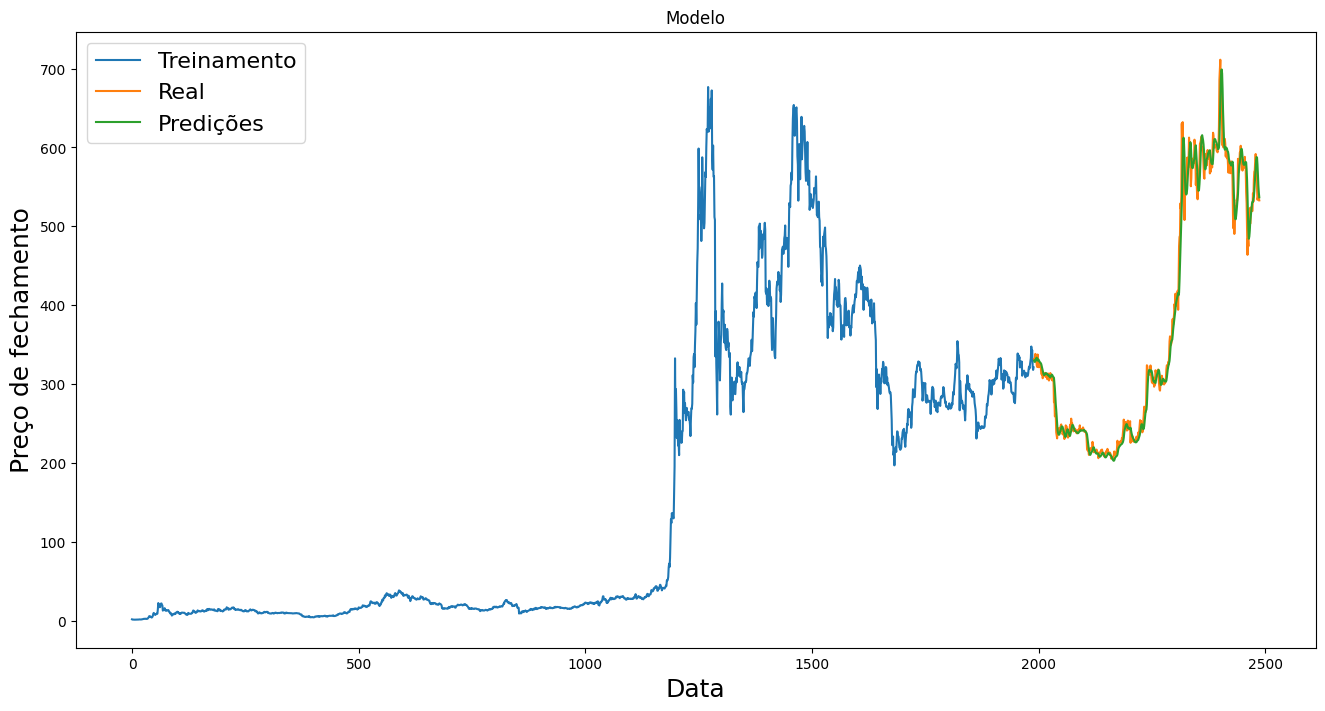

In [126]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Price'])
plt.plot(df_teste[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [127]:
df_teste.sort_index()

df_teste

,Price,predicoes
1990,332.08,329.978668
1991,330.70,328.343750
1992,331.10,328.239502
1993,338.39,329.012817
1994,330.50,331.664124
...,...,...
2483,533.68,578.223511
2484,536.60,564.080444
2485,536.51,551.588074
2486,535.21,542.517395


# Metricas para calcular nosso modelo de ML

### MAE (Mean Absolute Error)

In [133]:
# Calcular o MAE
mae = mean_absolute_error(df_teste['Price'], df_teste['predicoes'])

# Exibir o resultado
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 11.18


In [142]:
preco_medio = df_teste['Price'].mean()
print(f"Preço médio: {preco_medio}")

Preço médio: 376.0446586345381


In [141]:
erro_percent = (mae/preco_medio)*100 
print(f"Percentual de erro pelo Mean Absolute Error (MAE): {erro_percent:.3}%")

Percentual de erro pelo Mean Absolute Error (MAE): 2.97%


### Erro médio quadrático (RMSE)

In [128]:
rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.3385352824873716

### Directional Accuracy

In [129]:
# Cálculo da variação percentual entre os valores consecutivos
df_teste['variacao_real'] = df_teste['Price'].pct_change()
df_teste['variacao_prevista'] = df_teste['predicoes'].pct_change()

# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df = df_teste.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df['direcao_correta'] = np.where(
    (df['variacao_real'] > 0) & (df['variacao_prevista'] > 0) |
    (df['variacao_real'] < 0) & (df['variacao_prevista'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

df

Directional Accuracy: 49.30%


,Price,predicoes,variacao_real,variacao_prevista,direcao_correta
1991,330.70,328.343750,-0.004156,-0.004955,1
1992,331.10,328.239502,0.001210,-0.000318,0
1993,338.39,329.012817,0.022018,0.002356,1
1994,330.50,331.664124,-0.023316,0.008058,0
1995,330.70,332.967529,0.000605,0.003930,1
...,...,...,...,...,...
2483,533.68,578.223511,-0.026664,-0.015374,1
2484,536.60,564.080444,0.005471,-0.024460,0
2485,536.51,551.588074,-0.000168,-0.022146,1
2486,535.21,542.517395,-0.002423,-0.016445,1


In [111]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
ultimos_60_dias = acao['Price'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[516.0979]]
